In [1]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 96,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36647,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44733,Total threads: 8
Dashboard: http://127.0.0.1:38639/status,Memory: 83.91 GiB
Nanny: tcp://127.0.0.1:40597,


### Load MITgcm Output from Assimilations

In [2]:
folder_name = '/home/edavenport/analysis/mitgcm-mombudg/velocity_assim/OSM_2026/'

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13
import cmocean.cm as cmo
import xarray as xr
from open_tpose import tpose2012to2013
import numpy as np
import xarray as xr

prefix = ['diag_state','diag_surf','diag_mom_u']
ds_tpose_noTAO = tpose2012to2013(prefix)

ds_tpose_noTAO['XC'] = ds_tpose_noTAO.XC.astype(float)
ds_tpose_noTAO['YC'] = ds_tpose_noTAO.YC.astype(float)
ds_tpose_noTAO['Z'] = ds_tpose_noTAO.Z.astype(float)
ds_tpose_noTAO['XG'] = ds_tpose_noTAO.XG.astype(float)
ds_tpose_noTAO['YG'] = ds_tpose_noTAO.YG.astype(float)

mar2013/diags_daily/
may2013/diags_daily/
jul2013/diags_daily/
sep2013/diags_daily/
nov2013/diags_daily/
Days in 2012-2013: (should be 731)
731


In [6]:
from xmitgcm import open_mdsdataset
data_dir = '/data/SO3/edavenport/tpose6/sep2012/velocity_assim/run_iter22/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

offset = 10
num_diags = 30+31+offset #sep, oct + 10 days
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags,itPerFile)

ds = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200)

num_diags = 30+31+offset # nov, dec, 
itPerFile = 72 # 1 day
intervals = range(itPerFile*offset,itPerFile*num_diags,itPerFile)

data_dir = '/data/SO3/edavenport/tpose6/nov2012/run_iter20/'
ds_new = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-11-01',delta_t=1200)

ds_tpose_TAO = xr.concat([ds,ds_new],dim='time')

num_diags = 31+28+31 # jan, feb, march (starting from jan 10)
itPerFile = 72 # 1 day
intervals = range(itPerFile*offset,itPerFile*num_diags,itPerFile)

data_dir = '/data/SO3/edavenport/tpose6/jan2013/run_iter14/'
ds_new = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2013-01-01',delta_t=1200)

ds_tpose_TAO = xr.concat([ds_tpose_TAO,ds_new],dim='time')

# ds_tpose_TAO = ds_tpose_TAO.chunk({
#     'XC': 1,   # horizontal cell-centered
#     'XG': 1,   # horizontal staggered
#     'YC': -1,    # single chunk along Y to speed up mean reductions
#     'YG': -1,    # same for staggered Y
#     'Z': -1 ,    # vertical levels
#     'time': -1,
#     })

ds_tpose_TAO['XC'] = ds_tpose_TAO.XC.astype(float)
ds_tpose_TAO['YC'] = ds_tpose_TAO.YC.astype(float)
ds_tpose_TAO['Z'] = ds_tpose_TAO.Z.astype(float)
ds_tpose_TAO['XG'] = ds_tpose_TAO.XG.astype(float)
ds_tpose_TAO['YG'] = ds_tpose_TAO.YG.astype(float)

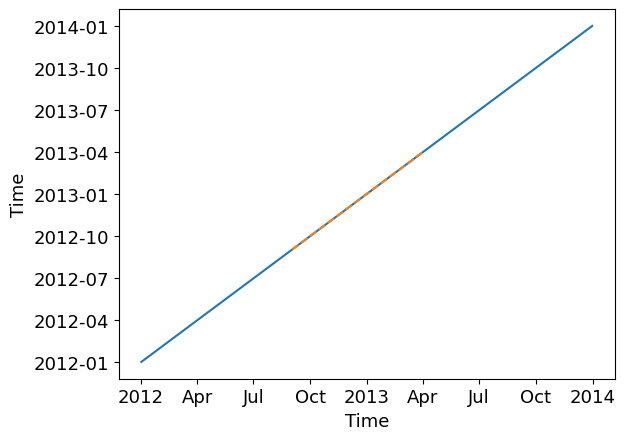

In [7]:
fig, ax = plt.subplots()
ds_tpose_noTAO.time.plot(ax=ax)
ds_tpose_TAO.time.plot(ax=ax,linestyle='--')

In [16]:
dt = ds_tpose_noTAO.time.diff("time")
dt_days = dt / np.timedelta64(1, "D")

dt_days.min().item(), dt_days.max().item()

(1.0, 1.0)

In [8]:
zMin = -250
zMax = 0
latMin = -0.1
latMax = 0.1

In [9]:
ds_tpose_noTAO = ds_tpose_noTAO.sel(time=slice('2012-09-01','2013-04-01')) # subset to sep 2012, april 2013
ds_tpose_TAO = ds_tpose_TAO.sel(time=slice('2012-09-01','2013-04-01')) # subset to sep 2012, april 2013

### Compute Momentum Budget Terms

In [10]:
import xgcm 

grid = xgcm.Grid(ds_tpose_noTAO, periodic=['X','Y'])
vol = (ds_tpose_noTAO.rAw*ds_tpose_noTAO.hFacW*ds_tpose_noTAO.drF)
KPP_momU = grid.diff(ds_tpose_noTAO.VISrI_Um,'Z',boundary='fill',fill_value=0)/vol
KPP_momU = KPP_momU.where(ds_tpose_noTAO.hFacW.values > 0,0) # set any nan fluxes to 0
ds_tpose_noTAO['Um_Advec'] = ds_tpose_noTAO.Um_Advec - ds_tpose_noTAO.Um_Cori

grid = xgcm.Grid(ds_tpose_TAO, periodic=['X','Y'])
vol = (ds_tpose_TAO.rAw*ds_tpose_TAO.hFacW*ds_tpose_TAO.drF)
KPP_momU_vel = grid.diff(ds_tpose_TAO.VISrI_Um,'Z',boundary='fill',fill_value=0)/vol
KPP_momU_vel = KPP_momU_vel.where(ds_tpose_TAO.hFacW.values > 0,0) # set any nan fluxes to 0
ds_tpose_TAO['Um_Advec'] = ds_tpose_TAO.Um_Advec - ds_tpose_TAO.Um_Cori

In [11]:
decorr_scale_days = 5 # see DecorrelationScales_MBTerms.py
N_ind = (90)/decorr_scale_days # approximate number of days in a season
std_err_denom = np.sqrt(N_ind)

In [12]:
KPP_momU_ext = KPP_momU + ds_tpose_noTAO.Um_Ext
KPP_momU_vel_ext = KPP_momU_vel + ds_tpose_TAO.Um_Ext

In [13]:
xg = ds_tpose_noTAO.XG

ix = [
    int(abs(xg - 190.).argmin()),
    int(abs(xg - 220.).argmin()),
    int(abs(xg - 250.).argmin())
]


In [17]:
TOTUTEND = (ds_tpose_noTAO.TOTUTEND
            .sel(YC=slice(latMin,latMax))
            .isel(XG=ix)
            .sel(Z=slice(zMax, zMin))
            .mean(['YC','time']) / 86400).compute()

KPP_momU_mean = (KPP_momU_ext.sel(YC=slice(latMin,latMax)).isel(XG=ix).sel(Z=slice(zMax, zMin)).mean(['YC','time'])).compute()
Um_Advec_mean = (ds_tpose_noTAO.Um_Advec.sel(YC=slice(latMin,latMax)).isel(XG=ix).sel(Z=slice(zMax, zMin)).mean(['YC','time'])).compute()
Um_dPhiX_mean = (ds_tpose_noTAO.Um_dPhiX.sel(YC=slice(latMin,latMax)).isel(XG=ix).sel(Z=slice(zMax, zMin)).mean(['YC','time'])).compute()

KPP_momU_std = (KPP_momU_ext.sel(YC=slice(latMin,latMax)).isel(XG=ix).sel(Z=slice(zMax, zMin)).mean('YC').std('time')/std_err_denom).compute()
Um_Advec_std = (ds_tpose_noTAO.Um_Advec.sel(YC=slice(latMin,latMax)).isel(XG=ix).sel(Z=slice(zMax, zMin)).mean('YC').std('time')/std_err_denom).compute()
Um_dPhiX_std = (ds_tpose_noTAO.Um_dPhiX.sel(YC=slice(latMin,latMax)).isel(XG=ix).sel(Z=slice(zMax, zMin)).mean('YC').std('time')/std_err_denom).compute()

TOTUTEND_vel = (ds_tpose_TAO.TOTUTEND
                .sel(YC=slice(latMin,latMax))
                .isel(XG=ix)
                .sel(Z=slice(zMax, zMin))
                .mean(['YC','time']) / 86400).compute()
KPP_momU_vel_mean = (KPP_momU_vel_ext.sel(YC=slice(latMin,latMax)).isel(XG=ix).sel(Z=slice(zMax, zMin)).mean(['YC','time'])).compute()
Um_Advec_vel_mean = (ds_tpose_TAO.Um_Advec.sel(YC=slice(latMin,latMax)).isel(XG=ix).sel(Z=slice(zMax, zMin)).mean(['YC','time'])).compute()
Um_dPhiX_vel_mean = (ds_tpose_TAO.Um_dPhiX.sel(YC=slice(latMin,latMax)).isel(XG=ix).sel(Z=slice(zMax, zMin)).mean(['YC','time'])).compute()

KPP_momU_vel_std = (KPP_momU_vel_ext.sel(YC=slice(latMin,latMax)).isel(XG=ix).sel(Z=slice(zMax, zMin)).mean('YC').std('time')/std_err_denom).compute()
Um_Advec_vel_std = (ds_tpose_TAO.Um_Advec.sel(YC=slice(latMin,latMax)).isel(XG=ix).sel(Z=slice(zMax, zMin)).mean('YC').std('time')/std_err_denom).compute()
Um_dPhiX_vel_std = (ds_tpose_TAO.Um_dPhiX.sel(YC=slice(latMin,latMax)).isel(XG=ix).sel(Z=slice(zMax, zMin)).mean('YC').std('time')/std_err_denom).compute()

/home/edavenport/miniforge3/envs/tpose/lib/python3.12/site-packages/distributed/client.py:3374: UserWarning: Sending large graph of size 26.86 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/edavenport/miniforge3/envs/tpose/lib/python3.12/site-packages/distributed/client.py:3374: UserWarning: Sending large graph of size 26.86 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/edavenport/miniforge3/envs/tpose/lib/python3.12/site-packages/distributed/client.py:3374: UserWarning: Sending large graph of si

In [18]:
terms = [
    dict(name='KPP',   color='tab:red',   label=r'$G_{mix}$'),
    dict(name='Advec', color='tab:blue',  label=r'$G_{adv}$'),
    dict(name='dPhiX', color='tab:olive', label=r'$G_{press}$'),
    dict(name='TOT',   color='k',         label=r'$\partial u/\partial t$')
]

lons = [190, 220, 250]     # your three longitudes
titles = ['170W', '140W', '110W']
xmin = -1.25*(10**-6)
xmax = 1.25*(10**-6)

In [19]:
# --- UVEL (no vel case) ---

uvel = (
    ds_tpose_noTAO.UVEL
      .sel(Z=slice(zMax, zMin), YC=slice(latMin, latMax))
      .isel(XG=ix)
      .mean('YC')
).compute()

EUC_Core = (
    ds_tpose_noTAO.Z
      .isel(Z=uvel.argmax('Z'))
      .mean('time')
      .compute()
)


# --- UVEL (vel case) ---

uvel_vel = (
    ds_tpose_TAO.UVEL
      .sel(Z=slice(zMax, zMin), YC=slice(latMin, latMax))
      .isel(XG=ix)
      .mean('YC')
).compute()

EUC_Core_vel = (
    ds_tpose_TAO.Z
      .isel(Z=uvel_vel.argmax('Z'))
      .mean('time')
      .compute()
)


In [20]:
def plot_budget_panel(axis, means, stds=None, euc_core=None, diff=False):

    for term in terms:

        m = means[term['name']]
        axis.plot(
            m, m.Z,
            linewidth=2.0,
            color=term['color'],
            label=term['label']
        )

        if stds is not None and not diff:
            if stds[term['name']] is not None and not diff:
                s = stds[term['name']]
                axis.fill_betweenx(
                    m.Z,
                    m - s,
                    m + s,
                    color=term['color'],
                    alpha=0.25
                )

    axis.axvline(0, linestyle='--', linewidth=0.4, color='k')

    if euc_core is not None:
        axis.axhline(euc_core, linestyle='--', linewidth=1.2, color='k',label='EUC core')

    axis.set_ylim(zMin, 0)
    axis.set_xlim(xmin, xmax)

In [21]:
EUC_Core_vel

<xarray.DataArray 'Z' (XG: 3)> Size: 24B
array([-137.51184834, -105.41469194,  -72.90995261])
Coordinates:
  * XG       (XG) float64 24B 190.0 220.0 250.0
Attributes:
    standard_name:  depth
    long_name:      vertical coordinate of cell center
    units:          m
    positive:       down
    axis:           Z

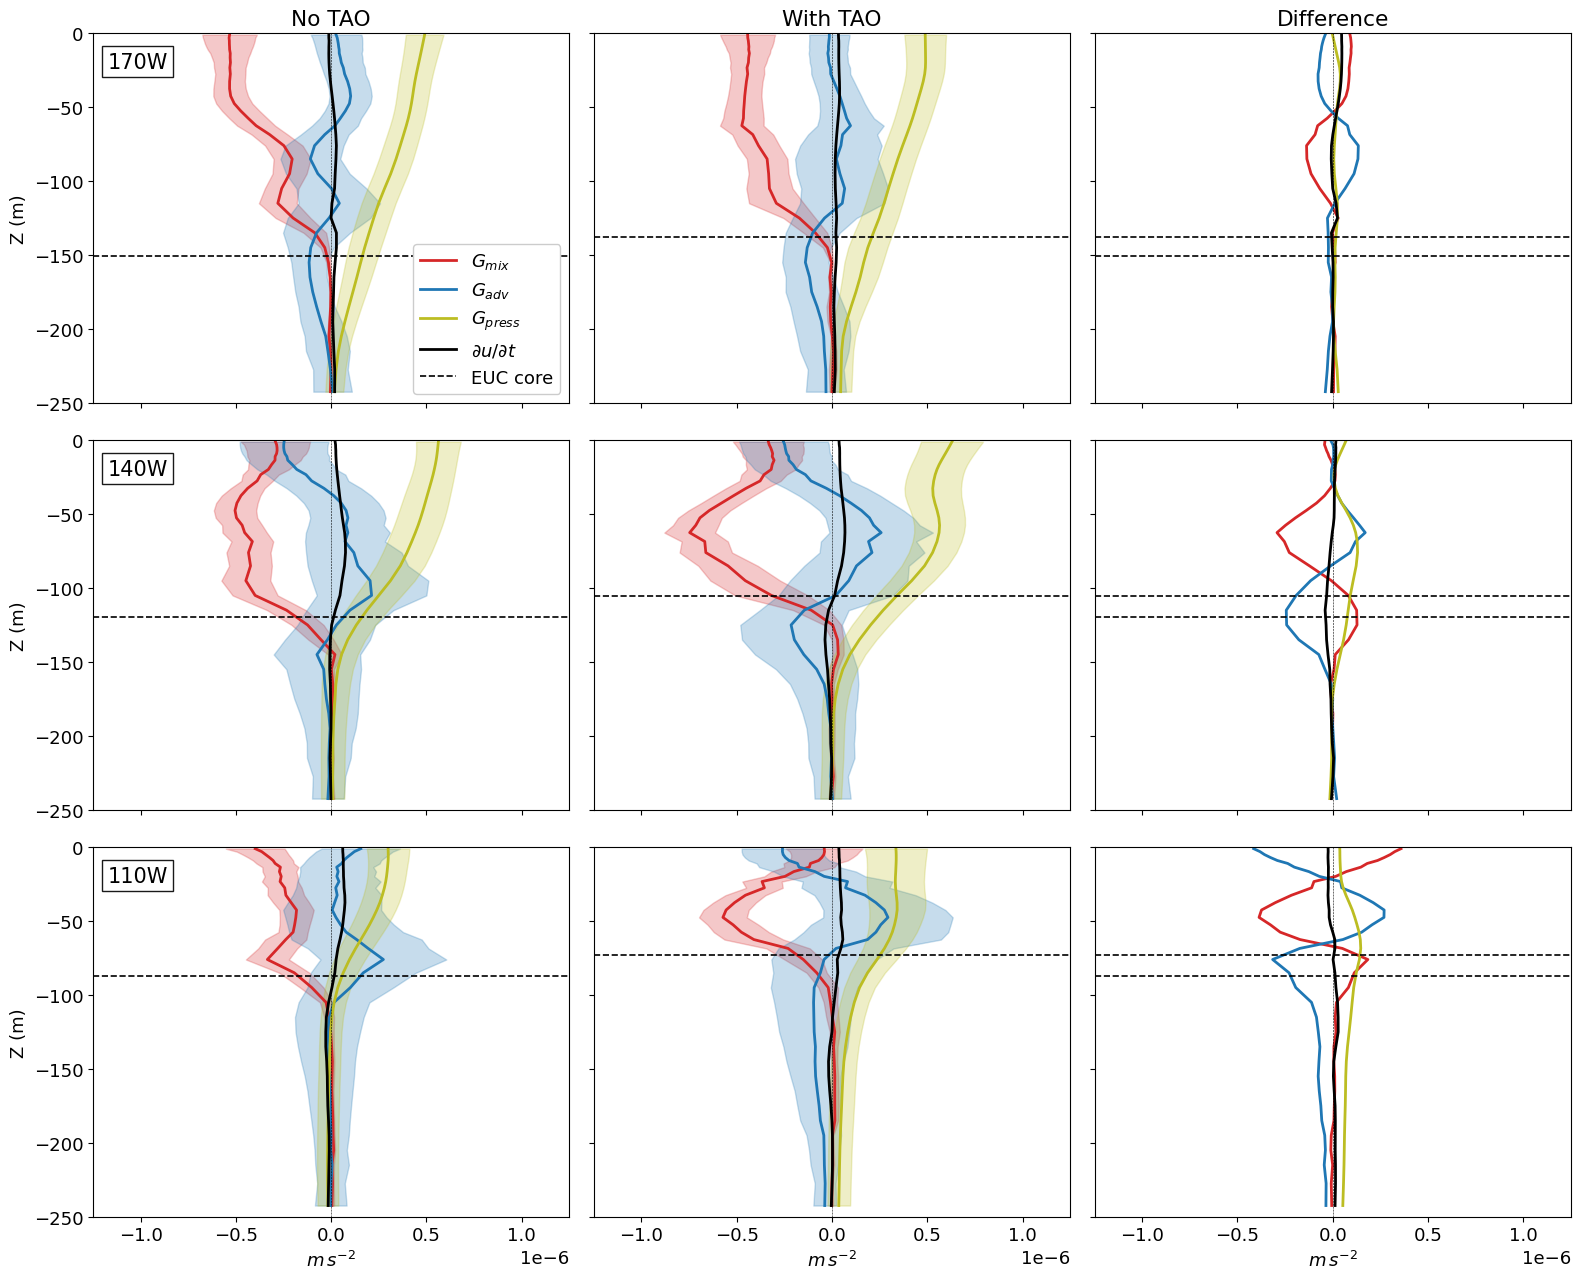

In [22]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(16, 13),
    sharex=True,
    sharey=True
)

for i, lon in enumerate(lons):

    # --- Gather data for this longitude ---
    means_no = dict(
        KPP=KPP_momU_mean.sel(XG=lon),
        Advec=Um_Advec_mean.sel(XG=lon),
        dPhiX=Um_dPhiX_mean.sel(XG=lon),
        TOT=TOTUTEND.sel(XG=lon)
    )

    stds_no = dict(
        KPP=KPP_momU_std.sel(XG=lon),
        Advec=Um_Advec_std.sel(XG=lon),
        dPhiX=Um_dPhiX_std.sel(XG=lon),
        TOT=None
    )

    means_vel = dict(
        KPP=KPP_momU_vel_mean.sel(XG=lon),
        Advec=Um_Advec_vel_mean.sel(XG=lon),
        dPhiX=Um_dPhiX_vel_mean.sel(XG=lon),
        TOT=TOTUTEND_vel.sel(XG=lon)
    )

    stds_vel = dict(
        KPP=KPP_momU_vel_std.sel(XG=lon),
        Advec=Um_Advec_vel_std.sel(XG=lon),
        dPhiX=Um_dPhiX_vel_std.sel(XG=lon),
        TOT=None
    )

    means_diff = {
        k: means_vel[k] - means_no[k]
        for k in means_no.keys()
    }

    # --- Column 0: No TAO ---
    plot_budget_panel(
        ax[i, 0],
        means_no,
        stds_no,
        euc_core=EUC_Core.sel(XG=lon)
    )

    # --- Column 1: With TAO ---
    plot_budget_panel(
        ax[i, 1],
        means_vel,
        stds_vel,
        euc_core=EUC_Core_vel.sel(XG=lon)
    )

    # --- Column 2: Difference ---
    plot_budget_panel(
        ax[i, 2],
        means_diff,
        stds=None,
        euc_core=None,
        diff=True
    )

    ax[i,2].axhline(EUC_Core.sel(XG=lon), linestyle='--', linewidth=1.2, color='k')
    ax[i,2].axhline(EUC_Core_vel.sel(XG=lon), linestyle='--', linewidth=1.2, color='k')

    # Row label (longitude inside first column)
    ax[i, 0].text(
        0.03, 0.95,
        titles[i],
        transform=ax[i, 0].transAxes,
        ha='left',
        va='top',
        fontsize=15,
        bbox=dict(facecolor='white', edgecolor='k', alpha=0.9)
    )

ax[0,0].set_title('No TAO')
ax[0,1].set_title('With TAO')
ax[0,2].set_title('Difference')
for j in range(3):
    ax[2,j].set_xlabel(r'$m \, s^{-2}$')

for i in range(3):
    ax[i,0].set_ylabel('Z (m)')

ax[0,0].legend(loc='lower right',framealpha=1)

plt.tight_layout()
fig.savefig(folder_name + 'mombudget_terms_meanprof_all_lons.png')

In [23]:
ds_mom_noTAO = xr.Dataset({'KPP_momU_mean': KPP_momU_mean, 
                           'AdvUm_Advec_meanec': Um_Advec_mean, 
                           'Um_dPhiX_mean': Um_dPhiX_mean, 
                           'TOTUTEND': TOTUTEND, 
                           'KPP_momU_std': KPP_momU_std, 
                           'Um_Advec_std': Um_Advec_std, 
                           'Um_dPhiX_std': Um_dPhiX_std,
                           'EUC_Core': EUC_Core})
ds_mom_noTAO.to_netcdf(folder_name + 'mombudget_terms_noTAO.nc')
ds_mom_TAO = xr.Dataset({'KPP_momU_vel_mean': KPP_momU_vel_mean, 
                           'Um_Advec_vel_mean': Um_Advec_vel_mean, 
                           'Um_dPhiX_vel_mean': Um_dPhiX_vel_mean, 
                           'TOTUTEND_vel': TOTUTEND_vel, 
                           'KPP_momU_vel_std': KPP_momU_vel_std, 
                           'Um_Advec_vel_std': Um_Advec_vel_std, 
                           'Um_dPhiX_vel_std': Um_dPhiX_vel_std,
                           'EUC_Core_vel': EUC_Core_vel})
ds_mom_TAO.to_netcdf(folder_name + 'mombudget_terms_TAO.nc')

In [ ]:
client.shutdown()
cluster.close()
client.close()